### Importing Libraries

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import zipfile

# Define paths for extraction
zip_path_train = '/content/train_dataset.zip'


extract_path_train = '/content/train_dataset'


# Function to extract a zip file
def extract_zip(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Extract train_dataset.zip
extract_zip(zip_path_train, extract_path_train)
print(f"Train dataset extracted to {extract_path_train}")



Train dataset extracted to /content/train_dataset


### Reading train.csv and Data Analysis

In [2]:
# Load train.csv
train_csv = pd.read_csv("train.csv")  # Replace with the actual path to your train.csv

# Mappings for converting labels to integers and vice-versa
label_to_int_map = {
    'bright dune': 0,
    'dark dune': 1,
    'spider': 2,
    'impact ejecta': 3,
    'slope streak': 4,
    'swiss cheese': 5,
    'crater': 6,
    'other': 7
}

int_to_label_map = {v:k for k, v in label_to_int_map.items()}

# Replace labels with integers
labels_int = train_csv['Class'].replace(label_to_int_map).tolist()

# Construct file paths considering nested structure
file_names = train_csv['File Name']
new_file_names = [os.path.join(extract_path_train, 'train_dataset', fname) for fname in file_names]

In [3]:

# Split into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(new_file_names, labels_int, test_size=0.2, random_state=42)

# Create DataFrames
train_df = pd.DataFrame({'file_path': x_train, 'label': y_train})
test_df = pd.DataFrame({'file_path': x_test, 'label': y_test})

# Define transformation for images
IMAGE_SIZE = (224, 224)
data_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.RandomHorizontalFlip(p=0.6),
    transforms.ToTensor(),
])

In [4]:
freq_df = train_df['label'].value_counts()
print(freq_df)

# Separate the DataFrame into different classes based on the label
df0 = train_df[train_df['label'] == 0].copy()
df1 = train_df[train_df['label'] == 1].copy()
df2 = train_df[train_df['label'] == 2].copy()
df3 = train_df[train_df['label'] == 3].copy()
df4 = train_df[train_df['label'] == 4].copy()
df5 = train_df[train_df['label'] == 5].copy()
df6 = train_df[train_df['label'] == 6].copy()
df7 = train_df[train_df['label'] == 7].copy()

# Duplicate and shuffle the data
df0 = pd.concat([df0 for k in range(2)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df1 = pd.concat([df1 for k in range(4)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df2 = pd.concat([df2 for k in range(9)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df3 = pd.concat([df3 for k in range(11)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df4 = pd.concat([df4 for k in range(4)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df5 = pd.concat([df5 for k in range(4)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df6 = pd.concat([df6 for k in range(2)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df7 = pd.concat([df7 for k in range(1)], ignore_index=True).sample(frac=1).reset_index(drop=True)

# Concatenate all the data back into a single DataFrame and shuffle
train_df_all = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7], ignore_index=True).sample(frac=1).reset_index(drop=True)
print(train_df_all['label'].value_counts())

# Define the number of examples to be taken from each class
noel = [600, 350, 300, 250, 600, 400, 1000, 1500]

# Create two new training DataFrames with specific number of examples from each class
train_df_1 = pd.concat([df0[:noel[0]],
                         df1[:noel[1]],
                         df2[:noel[2]],
                         df3[:noel[3]],
                         df4[:noel[4]],
                         df5[:noel[5]],
                         df6[:noel[6]],
                         df7[:noel[7]]], ignore_index=True).sample(frac=1).reset_index(drop=True)

train_df_2 = pd.concat([df0[-noel[0]:],
                         df1[-noel[1]:],
                         df2[-noel[2]:],
                         df3[-noel[3]:],
                         df4[-noel[4]:],
                         df5[-noel[5]:],
                         df6[-noel[6]:],
                         df7[-noel[7]:]], ignore_index=True).sample(frac=1).reset_index(drop=True)

# Print the shapes of the new DataFrames
print(train_df_1.shape, train_df_2.shape)

label
7    2912
6     840
0     482
4     277
1     178
5     178
2      51
3      42
Name: count, dtype: int64
label
7    2912
6    1680
4    1108
0     964
1     712
5     712
3     462
2     459
Name: count, dtype: int64
(5000, 2) (5000, 2)


### Importing the Images and creation of iterators for training
Images are imported as a PyTorch Dataset based on the filenames in the training and testing dataframes and the iterators are initiated

In [5]:
'''
Creating a class that will take in the train/test filenames dataframe
as input and import and store images as a tuple: (image tensor, integer label)

'''
# Dataset class for Mars images
class MarsImgDataset(Dataset):
    def __init__(self, img_df, transform=None):
        self.img_df = img_df
        self.transform = transform

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        img_path = self.img_df.iloc[idx, 0]
        label = self.img_df.iloc[idx, 1]

        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        return image, label


In [6]:
train_dataset_1 = MarsImgDataset(train_df_1, data_transform)
train_dataset_2 = MarsImgDataset(train_df_2, data_transform)
test_dataset = MarsImgDataset(test_df, data_transform)

train_loader_1 = DataLoader(dataset=train_dataset_1, batch_size=32, shuffle=True) # Initialise Training Loader
train_loader_2 = DataLoader(dataset=train_dataset_2, batch_size=32, shuffle=True) # Initialise Training Loader
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True) # Initialise Testing Loader

# Get a batch of images from the test loader
images, labels = next(iter(test_loader))


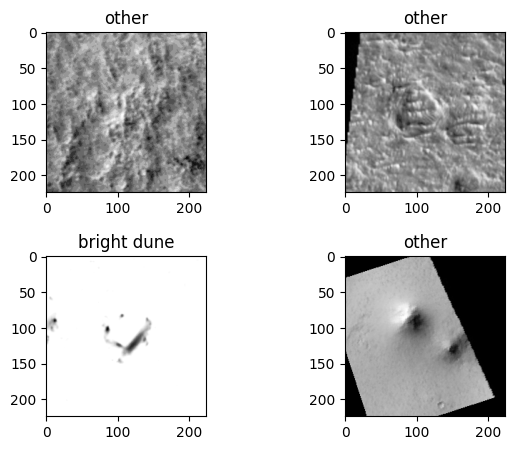

In [7]:
## Check the dataloaders by plotting the imported images
img, label = next(iter(test_loader))
figure, axis = plt.subplots(2,2)

axis[0,0].imshow(img[0].permute(1,2,0), cmap = 'Greys_r')
axis[0,0].set_title(int_to_label_map[label[0].item()])

axis[0,1].imshow(img[1].permute(1,2,0), cmap = 'Greys_r')
axis[0,1].set_title(int_to_label_map[label[1].item()])

axis[1,0].imshow(img[2].permute(1,2,0), cmap = 'Greys_r')
axis[1,0].set_title(int_to_label_map[label[2].item()])

axis[1,1].imshow(img[3].permute(1,2,0), cmap = 'Greys_r')
axis[1,1].set_title(int_to_label_map[label[3].item()])

plt.subplots_adjust(
    left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4
)

plt.show()


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [9]:
# # Creating a CNN-based image classifier.
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(1, 64, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(64, 512, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.conv_layer_3 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=512*3*3, out_features=8))
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.classifier(x)
        return x
# Instantiate an object.
model = ImageClassifier().to(device)


In [10]:
load = False #### SET TO TRUE IF YOU HAVE A PRESAVED CHECKPOINT

In [11]:
if load:
    checkpoint = torch.load("attempt2.pt")
    model.load_state_dict(checkpoint['model_state_dict'])

In [12]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_loader_1))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 1, 224, 224])

Output logits:
tensor([[ 0.0079, -0.0068,  0.0043,  0.0193,  0.0105,  0.0093,  0.0088,  0.0086]],
       device='cuda:0')

Output prediction probabilities:
tensor([[0.1250, 0.1232, 0.1246, 0.1264, 0.1253, 0.1252, 0.1251, 0.1251]],
       device='cuda:0')

Output prediction label:
tensor([3], device='cuda:0')

Actual label:
7


In [13]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
# do a test pass through of an example input size
summary(model, input_size=[1, 1, IMAGE_WIDTH ,IMAGE_HEIGHT])

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [1, 8]                    --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         640
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─BatchNorm2d: 2-3                  [1, 64, 224, 224]         128
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 512, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 512, 112, 112]        295,424
│    └─ReLU: 2-6                         [1, 512, 112, 112]        --
│    └─BatchNorm2d: 2-7                  [1, 512, 112, 112]        1,024
│    └─MaxPool2d: 2-8                    [1, 512, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 512, 56, 56]          2,359,80

In [14]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix, Precision, Recall, F1Score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 7.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [15]:
from torchmetrics import ConfusionMatrix, Precision, Recall, F1Score

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

     # Define metrics
    precision = Precision(average='macro', num_classes=8, task='MULTICLASS').to(device)
    recall = Recall(average='macro', num_classes=8, task='MULTICLASS').to(device)
    f1 = F1Score(average='macro', num_classes=8, task='MULTICLASS').to(device)

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        # Update metrics
        precision.update(y_pred_class, y)
        recall.update(y_pred_class, y)
        f1.update(y_pred_class, y)


    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    # Compute precision, recall, f1 score, and confusion matrix
    train_precision = precision.compute().item()
    train_recall = recall.compute().item()
    train_f1 = f1.compute().item()


    return train_loss, train_acc, train_precision, train_recall, train_f1





In [16]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Define metrics
    precision = Precision(average='macro', num_classes=8, task='MULTICLASS').to(device)
    recall = Recall(average='macro', num_classes=8, task='MULTICLASS').to(device)
    f1 = F1Score(average='macro', num_classes=8, task='MULTICLASS').to(device)

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

            precision.update(test_pred_labels, y)
            recall.update(test_pred_labels, y)
            f1.update(test_pred_labels, y)




    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

     # Compute precision, recall, f1 score, and confusion matrix
    test_precision = precision.compute().item()
    test_recall = recall.compute().item()
    test_f1 = f1.compute().item()


    return test_loss, test_acc, test_precision, test_recall, test_f1





In [17]:
# Define the train function
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
          train_dataloader_1: torch.utils.data.DataLoader,
          train_dataloader_2: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          results = None,
          done_epochs = 0):
    # Create empty results dictionary
    if results == None:
        results = {
            "train_loss": [],
            "train_acc": [],
            "train_precision": [],
            "train_recall": [],
            "train_f1": [],

            "test_loss": [],
            "test_acc": [],
            "test_precision": [],
            "test_recall": [],
            "test_f1": []}


    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(done_epochs, epochs+done_epochs)):
        if epoch%2 == 0:
            train_dataloader = train_dataloader_1
        else:
            train_dataloader = train_dataloader_2

        train_loss, train_acc, train_precision, train_recall, train_f1 = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer)

        test_loss, test_acc, test_precision, test_recall, test_f1 = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"train_precision: {train_precision:.4f} | "
            f"train_recall: {train_recall:.4f} | "
            f"train_f1: {train_f1:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"test_precision: {test_precision:.4f} | "
            f"test_recall: {test_recall:.4f} | "
            f"test_f1: {test_f1:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_precision"].append(train_precision)
        results["train_recall"].append(train_recall)
        results["train_f1"].append(train_f1)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_precision"].append(test_precision)
        results["test_recall"].append(test_recall)
        results["test_f1"].append(test_f1)

        torch.save({
                    'model_state_dict':model.state_dict(),
                    'opt_state_dict': optimizer.state_dict(),
                    'results':results,
                    'epoch':epoch
                }, "attempt2.pt")

    # Return the filled results at the end of the epochs
    return results

In [18]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 60

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0002)

if load:
    optimizer.load_state_dict(checkpoint['opt_state_dict'])
    results = checkpoint['results']
    done_epochs = checkpoint['epoch']
else:
    results = None
    done_epochs = 0

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = train(model=model,
                      train_dataloader_1=train_loader_1,
                      train_dataloader_2=train_loader_2,
                      test_dataloader=test_loader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      results=results,
                      done_epochs=done_epochs)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7796 | train_acc: 0.3694 | train_precision: 0.3160 | train_recall: 0.2966 | train_f1: 0.2990 | test_loss: 1.3919 | test_acc: 0.5160 | test_precision: 0.2964 | test_recall: 0.3199 | test_f1: 0.2899
Epoch: 2 | train_loss: 1.4073 | train_acc: 0.4986 | train_precision: 0.4806 | train_recall: 0.4418 | train_f1: 0.4533 | test_loss: 1.3224 | test_acc: 0.5418 | test_precision: 0.3555 | test_recall: 0.3640 | test_f1: 0.3269
Epoch: 3 | train_loss: 1.2024 | train_acc: 0.5836 | train_precision: 0.5705 | train_recall: 0.5367 | train_f1: 0.5480 | test_loss: 0.9666 | test_acc: 0.6588 | test_precision: 0.5164 | test_recall: 0.4726 | test_f1: 0.4462
Epoch: 4 | train_loss: 1.0047 | train_acc: 0.6493 | train_precision: 0.6496 | train_recall: 0.6182 | train_f1: 0.6311 | test_loss: 1.1254 | test_acc: 0.6111 | test_precision: 0.4218 | test_recall: 0.4318 | test_f1: 0.3685
Epoch: 5 | train_loss: 0.9148 | train_acc: 0.6789 | train_precision: 0.6887 | train_recall: 0.6562 | train_f1: 0

In [19]:
def plot_loss_curves(results):

    results = dict(list(model_results.items()))

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    precision = results['train_precision']
    test_precision = results['test_precision']

    recall = results['train_recall']
    test_recall = results['test_recall']

    f1 = results['train_f1']
    test_f1 = results['test_f1']




    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

    # Plot precision
    plt.subplot(2, 3, 3)
    plt.plot(epochs, precision, label='train_precision')
    plt.plot(epochs, test_precision, label='test_precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot recall
    plt.subplot(2, 3, 4)
    plt.plot(epochs, recall, label='train_recall')
    plt.plot(epochs, test_recall, label='test_recall')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.legend();

    plt.subplot(2, 3, 5)
    plt.plot(epochs, f1, label='train_f1')
    plt.plot(epochs, test_f1, label='test_f1')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.legend();
    plt.tight_layout()





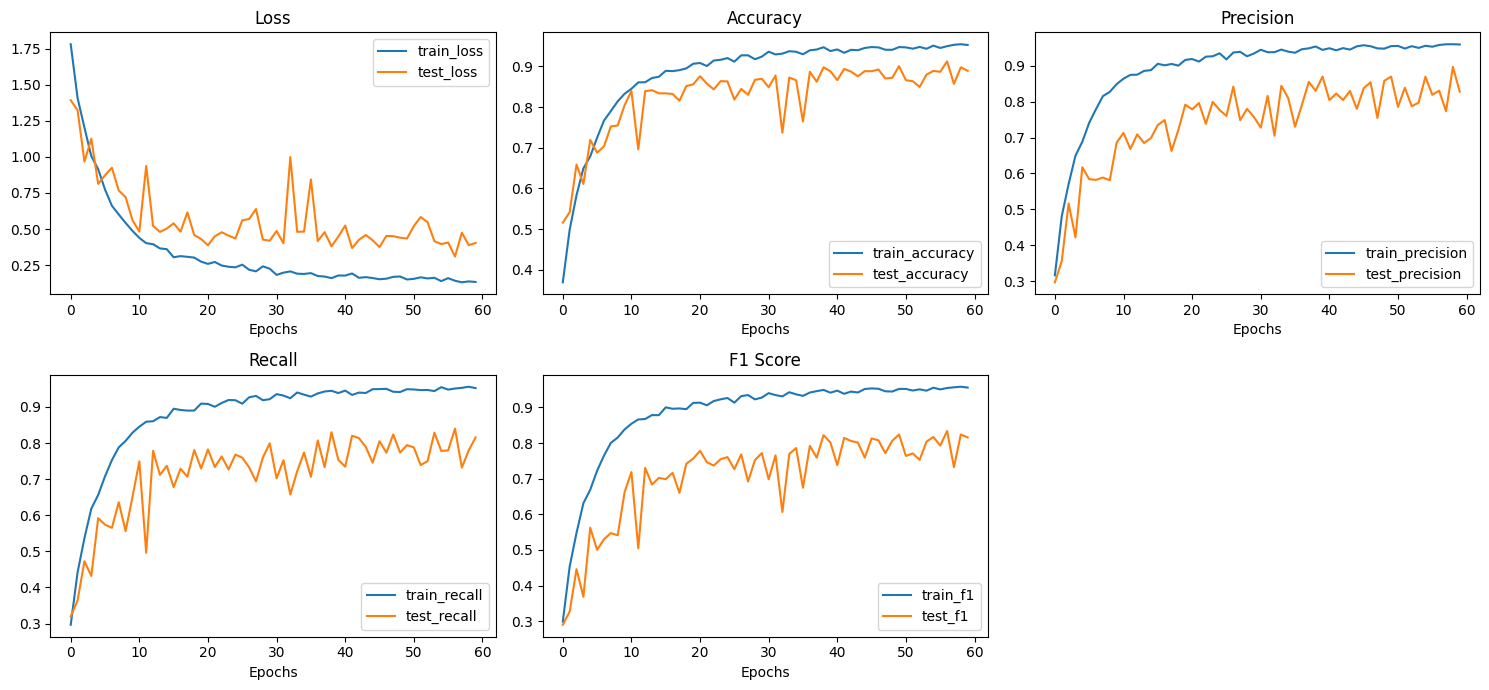

In [20]:
plot_loss_curves(model_results)